Sentiment Analysis

These reviews are scraped from capital one website for the capital one platinum credit card.


https://www.freelancer.com/get/EngDinaa?f=give

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
import string
import re
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS 



import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
data = pd.read_excel('Reviews.xlsx')
print(data.shape)
print(data.columns)

(5180, 9)
Index(['Review Title', 'Profile Name', 'Location', 'Cardholder For', 'Age',
       'Usage', 'Rating', 'Review Date', 'Full Review'],
      dtype='object')


In [3]:
#convert rating to numbers
data['Rating']= [i.split(' stars', 1)[0] for i in data['Rating']]
data['Rating']=pd.to_numeric(data['Rating'])

#convert Date to datatime type
data['Review Date']=pd.to_datetime(data['Review Date'])

In [4]:
#we will define rating of 5,4 as positive review, with 1,2 as negative review and 3 as Neutral review

def f(row):
    if row['Rating'] >= 4:
        val = 2
    elif row['Rating'] <= 2:
        val = 0
    else:
        val = 1
    return val

data['sentiment'] = data.apply(f, axis=1)


In [5]:
print(data.isnull().sum())

Review Title      977
Profile Name       42
Location          385
Cardholder For      0
Age               106
Usage               0
Rating              0
Review Date         0
Full Review         0
sentiment           0
dtype: int64


In [6]:
data["Profile Name"].fillna("Not Defined", inplace = True)
data["Location"].fillna("Not Defined", inplace = True)
data["Age"].fillna("Not Defined", inplace = True)

In [7]:
data.head()

,Review Title,Profile Name,Location,Cardholder For,Age,Usage,Rating,Review Date,Full Review,sentiment
0,everything works great,esch,Minnesota,1 - 3 years,45 - 54,Monthly,5,2020-02-14,helps with budget by sorting into expense cat...,2
1,I think it's a great card,Russell tussle,Dallas Texas,3 - 8 years,55 - 64,Monthly,5,2020-02-14,I think my Capital One card is a great fit for...,2
2,"Easy access, security and peace of mind I hope.",4 the hard way,Illinois,6 months - 1 year,55 - 64,Weekly,5,2020-02-14,This card is known world wide and excepted eve...,2
3,Love the app,KetV,Kentucky,6 months - 1 year,29 - 34,Monthly,5,2020-02-14,Ease of access on the app. Customer service is...,2
4,Love all the features in the app.,bpopbry,California,6 months - 1 year,55 - 64,Daily,5,2020-02-14,"I like that there's no anually fees, and you c...",2


In [8]:
data.groupby("Age")["Full Review"].count()

Age
18 - 28         500
29 - 34         614
35 - 44        1241
45 - 54        1345
55 - 64         920
Not Defined     106
Over 65         454
Name: Full Review, dtype: int64

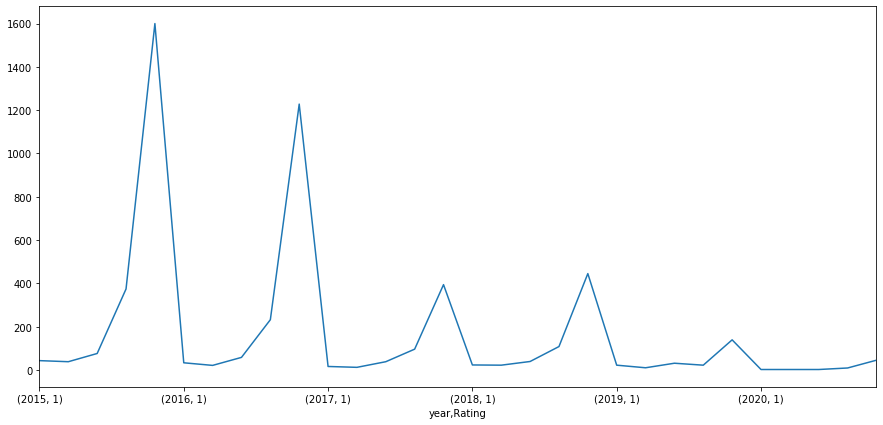

In [9]:
#Rating during years
p_df = data[['Rating','Review Date','Full Review']]
p_df['year']=pd.DatetimeIndex(p_df['Review Date']).year
fig, ax = plt.subplots(figsize=(15,7))
p_df.groupby(['year','Rating']).count()['Full Review'].plot(ax=ax)

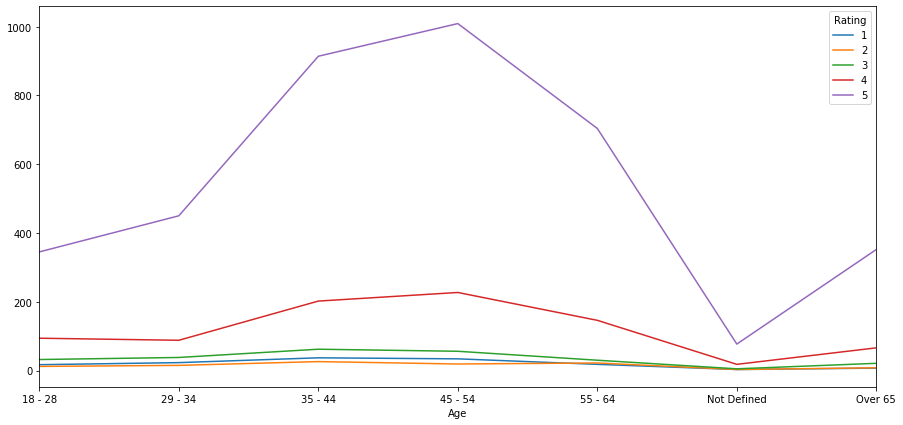

In [10]:
#data.groupby(["Age", "Rating"])["Full Review"].count()
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['Age','Rating'])["Full Review"].count().unstack().plot(ax=ax)

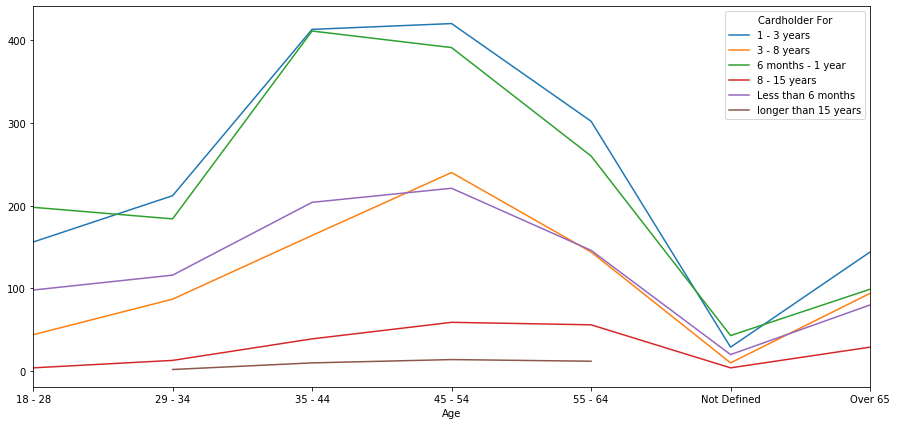

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['Age','Cardholder For'])["Full Review"].count().unstack().plot(ax=ax)

In [12]:
pos_data= data.sort_values(['Review Date', 'Rating'], ascending=[False, False])
pos_data[['Profile Name','Rating','Review Date','Age','Cardholder For']].head()

,Profile Name,Rating,Review Date,Age,Cardholder For
0,esch,5,2020-02-14,45 - 54,1 - 3 years
1,Russell tussle,5,2020-02-14,55 - 64,3 - 8 years
2,4 the hard way,5,2020-02-14,55 - 64,6 months - 1 year
3,KetV,5,2020-02-14,29 - 34,6 months - 1 year
4,bpopbry,5,2020-02-14,55 - 64,6 months - 1 year


In [13]:
neg_data= data.sort_values(['Review Date','Rating'], ascending=[False, True])
neg_data[['Profile Name','Rating','Review Date','Age','Cardholder For']].head()

,Profile Name,Rating,Review Date,Age,Cardholder For
17,New capital one,1,2020-02-14,55 - 64,1 - 3 years
6,Lb123123,2,2020-02-14,35 - 44,1 - 3 years
15,ANGEL 11,3,2020-02-14,45 - 54,1 - 3 years
8,Vinnie Can,4,2020-02-14,55 - 64,longer than 15 years
18,Vlo28,4,2020-02-14,45 - 54,6 months - 1 year


In [14]:
pos_data.head(20).iplot(
    x='Rating',
    y='Profile Name',
    xTitle='Rating',
    yTitle='Profile Name',
    mode='markers',
    title='The latest top rating profiles according to Date')

In [15]:
# function for text cleaning 
def clean_text(text): 
    text=re.sub(r'[^\w\s]', '', text.lower()).replace("  ", " ").replace("\n", "")
    text=" ".join(lemma.lemmatize(word.strip()) for word in text.split() if word not in stopwords ) 
    text=" ".join(word for word in text.split() if word not in stopwords)
    return text

data['clean_Review'] = data['Full Review'].apply(lambda x: clean_text(x))
data['word_count']= data['clean_Review'].apply(lambda x: len(str(x).split()))

Text(0, 0.5, 'Number of reviews ')

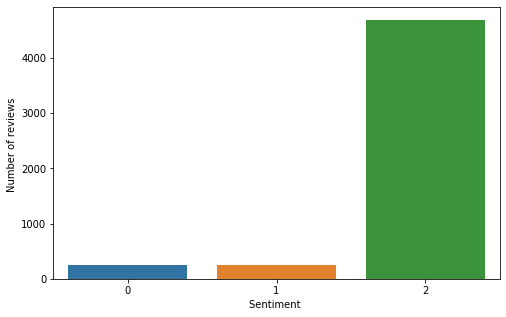

In [16]:
#The sentiment labels are: 0- negative 1-neutral 2-positive
class_count = data['sentiment'].value_counts()
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

In [17]:
#The distribution of review ratings
data['Rating'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

In [18]:
#Review Text Word Count Distribution
data['word_count'].iplot(
    kind='hist',
    bins=150,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

In [19]:
#Using Word Clouds to see the higher fequency words from each sentiment
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

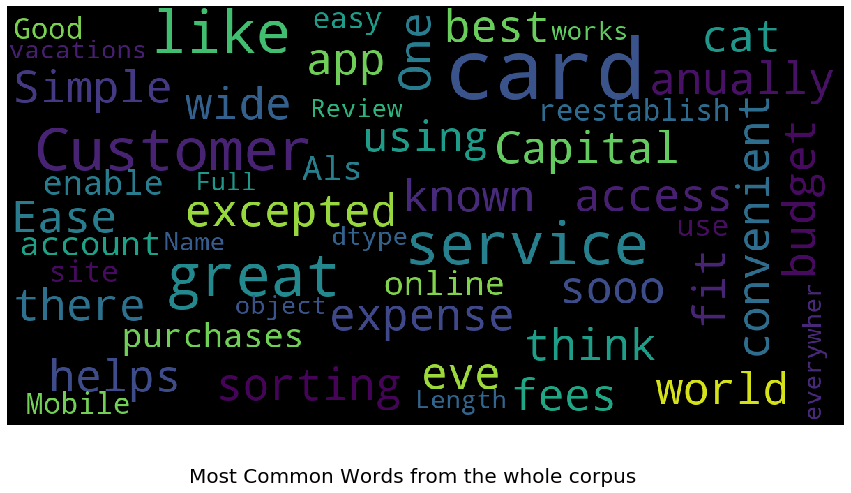

In [20]:
show_wordcloud(data['Full Review'],'Most Common Words from the whole corpus')

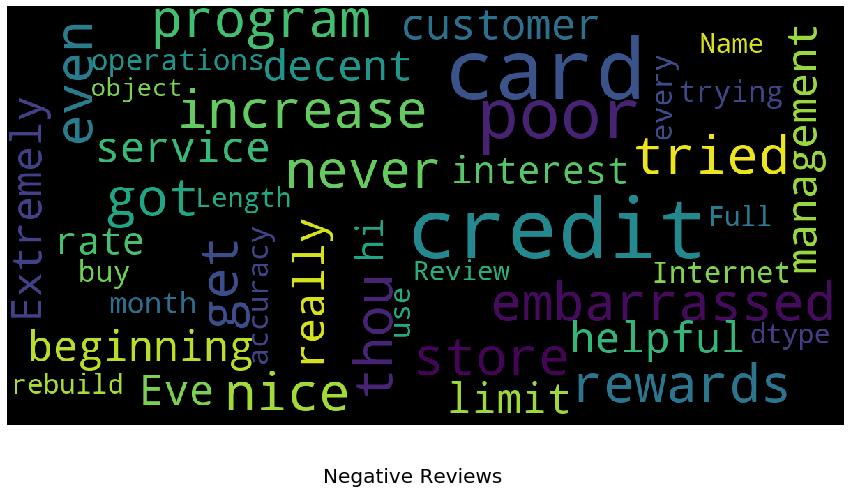

In [21]:
show_wordcloud(data[data['sentiment'] == 0]['Full Review'],'Negative Reviews')

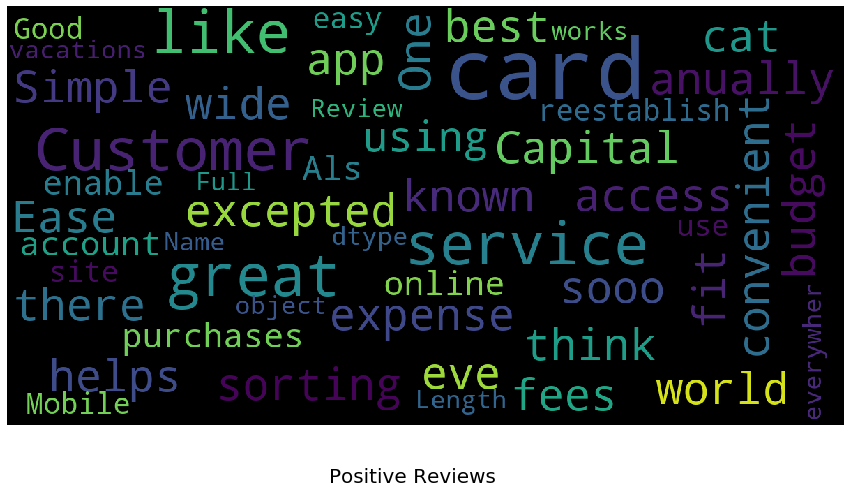

In [22]:
show_wordcloud(data[data['sentiment'] == 2]['Full Review'],'Positive Reviews')

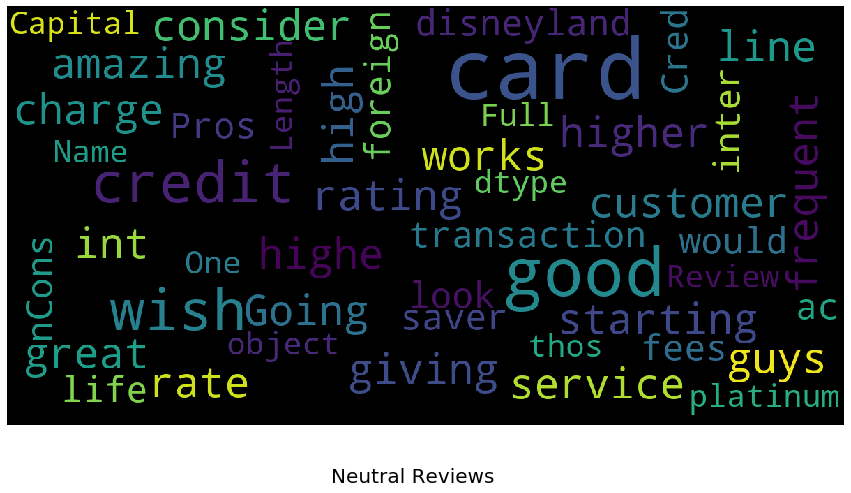

In [23]:
show_wordcloud(data[data['sentiment'] == 1]['Full Review'],'Neutral Reviews')

In [24]:
X=data['clean_Review']
y=data['sentiment']
from sklearn.model_selection import StratifiedShuffleSplit
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)
print(len(X_train), len(X_test))

4144 1036


In [25]:
# CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(4144, 3309)

In [26]:
# tfidf
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(4144, 3309)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf_nominalNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == y_test)

0.9054054054054054

In [29]:
text="I love my capital one android application As well as the customer service reps when I need to call in or have questions. All around I love capital one!"
predicted=clf_multiNB_pipe.predict([text])
if predicted[0] == 2 :
    print("This is Positive sentiment")
elif predicted[0] == 1:
    print("This is Neutral sentiment")
else:
    print("This is Negative sentiment")

This is Positive sentiment


Conclusion

•Based on the Data, 5 rating is the most rating found, since there are about 3900 review with 5 rating .

•The Latest Profiles that have Top rating are(esch, Russell tussle, the hard way, KetV, bpopbry)

•The Latest Profiles that have Down rating are(New capital one, Lb123123)

•The review Word Count Distribution range from about 5 to 800.

•The Age of most users between 35 to 64

•The most users have Cardholder For 6months-1year and 1year-3year

•By years number of users become lower.

•Words from Negative reviews(Limit, poor, never, rebuild,limit, customer)

•Words from Positive reviews(like, Expected, service, great, online, helps)